                                                   text_  labelzahl
0                                                  text_          0
1      Love this!  Well made, sturdy, and very comfor...          1
2      love it, a great upgrade from the original.  I...          1
3      This pillow saved my back. I love the look and...          1
4      Missing information on how to use it, but it i...          1
...                                                  ...        ...
40428  I had read some reviews saying that this bra r...          0
40429  I wasn't sure exactly what it would be. It is ...          1
40430  You can wear the hood by itself, wear it with ...          0
40431  I liked nothing about this dress. The only rea...          1
40432  I work in the wedding industry and have to wor...          0

[40433 rows x 2 columns]
Review Eva is on her to find a way to escape her abusive mother. When she meets a handsome stranger she doesn't know is the man she wants but the man she want

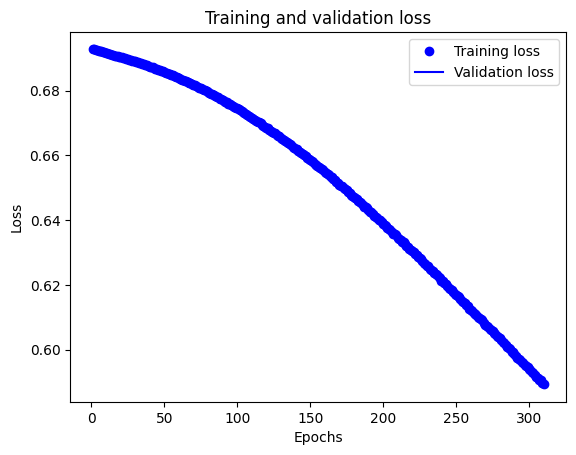

                                                   text_  labelzahl
0                                                  text_          0
1      Love this!  Well made, sturdy, and very comfor...          1
2      love it, a great upgrade from the original.  I...          1
3      This pillow saved my back. I love the look and...          1
4      Missing information on how to use it, but it i...          1
...                                                  ...        ...
40428  I had read some reviews saying that this bra r...          0
40429  I wasn't sure exactly what it would be. It is ...          1
40430  You can wear the hood by itself, wear it with ...          0
40431  I liked nothing about this dress. The only rea...          1
40432  I work in the wedding industry and have to wor...          0

[40433 rows x 2 columns]
Abschnitt printen
                                                text_  labelzahl
25  Supposed to come with extra hardware. The only...          1
26  Easy t

'Werte größer als 0 sind Fake Reviews'

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from keras import layers
from keras import losses
import numpy as np
import torch

from numpy.random import seed
seed(42)

#OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews.
df = pd.read_csv(
    r"C:\Users\ma54276\Desktop\reviewDetector-main\python\fakereviews.csv",
    names=["category","rating","label","text_"])

#Electronics_5 = Electronics. Die 5 hat hier keine Bedeutung was die Sterne angeht.
df = df[["label","text_"]]

#Computer generierte Texte bekommen die Zahl 1 für spam zugeordnet. Im Grunde wird das Label in diesem und
#im nächsten Schritt nur als Zahl dargestellt zur einfacheren Verarbeitung.
df['labelzahl'] = df['label'].apply(lambda x: 1 if x=='CG' else 0)

datenset_xy = df[["text_","labelzahl"]]
print(datenset_xy)


def get_dataset_partitions_tf(ds=datenset_xy, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1

    train_ds=ds.sample(frac=0.8)
    val_test_ds=ds.drop(train_ds.index)
    val_ds=val_test_ds.sample(frac=0.5)
    test_ds=val_test_ds.drop(val_ds.index)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds=datenset_xy, train_split=0.8, val_split=0.1, test_split=0.1)


train_x = train_ds.pop('text_')
train_y = train_ds.pop('labelzahl')

val_x = val_ds.pop('text_')
val_y = val_ds.pop('labelzahl')

test_x = test_ds.pop('text_')
test_y = test_ds.pop('labelzahl')


max_features = 10000
sequence_length = 250

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


# The vocabulary for the layer must be either supplied on construction or learned via adapt().
vectorize_layer.adapt(train_x)
vectorize_layer.adapt(val_x)
vectorize_layer.adapt(test_x)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

text_batch, label_batch = next(iter(train_x)), next(iter(train_y))
print("Review", text_batch)
print("Label", label_batch)
print("Vectorized review", text_batch, label_batch)

print(" 381 ---> ",vectorize_layer.get_vocabulary()[381])
print(" 133 ---> ",vectorize_layer.get_vocabulary()[133])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))


train_x = vectorize_layer(train_x)
val_x = vectorize_layer(val_x)
test_x = vectorize_layer(test_x)

#################

train_x = tf.convert_to_tensor(train_x)
train_y = tf.convert_to_tensor(train_y)

train_x = tf.cast(train_x, tf.int32)
train_y = tf.cast(train_y, tf.int32)

train_x = tf.data.Dataset.from_tensors(train_x)
train_y = tf.data.Dataset.from_tensors(train_y)

################

val_x = tf.convert_to_tensor(val_x)
val_y = tf.convert_to_tensor(val_y)

val_x = tf.cast(val_x, tf.int32)
val_y = tf.cast(val_y, tf.int32)

val_x = tf.data.Dataset.from_tensors(val_x)
val_y = tf.data.Dataset.from_tensors(val_y)

#################

test_x = tf.convert_to_tensor(test_x)
test_y = tf.convert_to_tensor(test_y)

test_x = tf.cast(test_x, tf.int32)
test_y = tf.cast(test_y, tf.int32)

test_x = tf.data.Dataset.from_tensors(test_x)
test_y = tf.data.Dataset.from_tensors(test_y)

AUTOTUNE = tf.data.AUTOTUNE

train_x = train_x.cache().prefetch(buffer_size=AUTOTUNE)
train_y = train_y.cache().prefetch(buffer_size=AUTOTUNE)

val_x = val_x.cache().prefetch(buffer_size=AUTOTUNE)
val_y = val_y.cache().prefetch(buffer_size=AUTOTUNE)

test_x = test_x.cache().prefetch(buffer_size=AUTOTUNE)
test_y = test_y.cache().prefetch(buffer_size=AUTOTUNE)

embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

train_data_set = tf.data.Dataset.zip( (train_x , train_y) )
val_data_set = tf.data.Dataset.zip( (val_x , val_y) )
test_data_set = tf.data.Dataset.zip( (test_x , test_y) )

epochs = 310

history = model.fit(
    train_data_set,
    validation_data=val_data_set,
    epochs=epochs)

model.save('amazon_ein_input.keras')

loss, accuracy = model.evaluate(test_data_set)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


df = pd.read_csv(
    r"C:\Users\ma54276\Desktop\reviewDetector-main\python\fakereviews.csv",
    names=["category","rating","label","text_"])

#Electronics_5 = Electronics. Die 5 hat hier keine Bedeutung was die Sterne angeht.
df = df[["label","text_"]]

#Computer generierte Texte bekommen die Zahl 1 für spam zugeordnet. Im Grunde wird das Label in diesem und
#im nächsten Schritt nur als Zahl dargestellt zur einfacheren Verarbeitung.
df['labelzahl'] = df['label'].apply(lambda x: 1 if x=='CG' else 0)

datenset_xy = df[["text_","labelzahl"]]
print(datenset_xy)

print("Abschnitt printen")
print(datenset_xy.iloc[25:85])

predict_ds = datenset_xy.iloc[25:85]

predict_text = predict_ds.pop('text_').to_numpy()

predict_text = vectorize_layer(predict_text)

print("predict text printen")


print(predict_text)




prediction = model.predict(predict_text)

print("prediction")
print(prediction)

text = ["Supposed to come with extra hardware. The only problem is that it's not really a vacuum,"]

text = vectorize_layer(text)

prediction2 = model.predict(text)

print("prediction2")
print(prediction2)

"Werte größer als 0 sind Fake Reviews"
